In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# install autoFRK in development mode
import os
import sys
module_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))

!"{sys.executable}" -m pip uninstall -y autoFRK
!"{sys.executable}" -m pip install --upgrade pip build setuptools wheel matplotlib pandas torchviz graphviz cartopy
!"{sys.executable}" -m build {module_root}
!"{sys.executable}" -m pip install -e "{module_root}"

Found existing installation: autoFRK 1.2.0
Uninstalling autoFRK-1.2.0:
  Successfully uninstalled autoFRK-1.2.0
* Creating isolated environment: venv+pip...
* Installing packages in isolated environment:
  - setuptools>=61.0
  - wheel
* Getting build dependencies for sdist...
running egg_info
writing src\autoFRK.egg-info\PKG-INFO
writing dependency_links to src\autoFRK.egg-info\dependency_links.txt
writing requirements to src\autoFRK.egg-info\requires.txt
writing top-level names to src\autoFRK.egg-info\top_level.txt
reading manifest file 'src\autoFRK.egg-info\SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'src\autoFRK.egg-info\SOURCES.txt'
* Building sdist...
running sdist
running egg_info
writing src\autoFRK.egg-info\PKG-INFO
writing dependency_links to src\autoFRK.egg-info\dependency_links.txt
writing requirements to src\autoFRK.egg-info\requires.txt
writing top-level names to src\autoFRK.egg-info\top_level.txt
reading manifes

C:\Users\user\AppData\Local\Temp\build-env-k5b_5209\Lib\site-packages\setuptools\dist.py:483: SetuptoolsDeprecationWarning: Cannot find any files for the given pattern.
!!

        ********************************************************************************
        Pattern 'LICENCE*' did not match any files.

        By 2026-Mar-20, you need to update your project and remove deprecated calls
        or your builds will no longer be supported.
        ********************************************************************************

!!
  for path in sorted(cls._find_pattern(pattern, enforce_match))
C:\Users\user\AppData\Local\Temp\build-env-k5b_5209\Lib\site-packages\setuptools\dist.py:483: SetuptoolsDeprecationWarning: Cannot find any files for the given pattern.
!!

        ********************************************************************************
        Pattern 'LICENCE*' did not match any files.

        By 2026-Mar-20, you need to update your project and remove deprecated

Obtaining file:///C:/Users/user/Desktop/github/autoFRK-python
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for autoFRK (pyproject.toml): started
  Building editable for autoFRK (pyproject.toml): finished with status 'done'
  Created wheel for autoFRK: filename=autofrk-1.2.0-0.editable-py3-none-any.whl size=19840 sha256=cb33088341602e804c0fe280ac6527328d0af38663c5d0e5922c481b65951c2b
  Stored in directory: C:\Users\user\AppData\Local\Temp\pip-ephem-wheel-cache-3r8si07h\wheels\52\0c\c1\406639587ca52486dcaee85d6579cc2a329952ec

In [3]:
# import modules
import os
import sys
import numpy as np
import pandas as pd
import torch
from torch.nn.functional import mse_loss
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from autoFRK import AutoFRK, to_tensor, p, garbage_cleaner, setup_device

In [4]:
data_path = f'../../../Weather2K/weather2k.npy'
data = np.load(data_path)

In [5]:
# reshape data
data = data.transpose(1, 0, 2)
data.shape

(13, 1866, 13632)

In [6]:
# lat and lon and alt
lat_lon_alt = data[0:3, :, 0].T
data = data[3:, :, :]
print(lat_lon_alt)

[[ 52.97 122.51 439.7 ]
 [ 53.47 122.38 297.3 ]
 [ 52.35 124.72 363.  ]
 ...
 [ 18.77 109.52 329.7 ]
 [ 18.65 109.7   69.8 ]
 [ 18.8  110.33  41.1 ]]


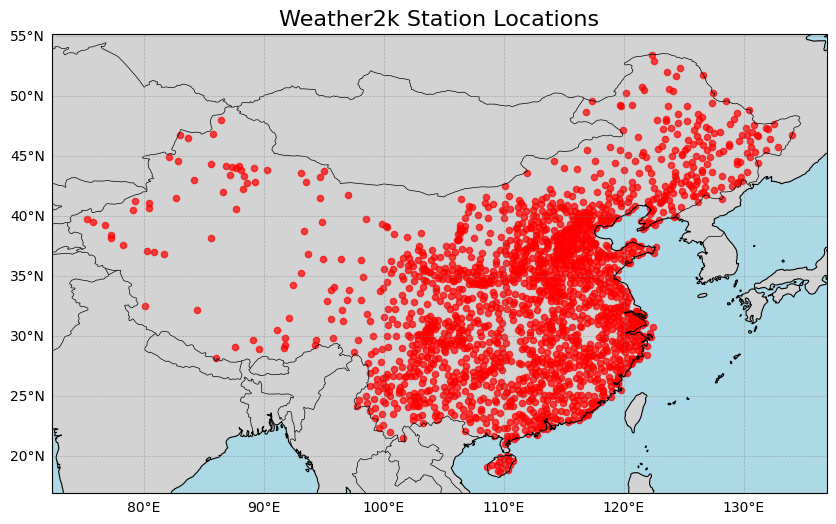

In [7]:
# Plot all stations
lats = lat_lon_alt[:, 0]
lons = lat_lon_alt[:, 1]

# Create the plot
plt.figure(figsize=(10, 12))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add base map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

# Add latitude and longitude gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'fontsize': 10}
gl.ylabel_style = {'fontsize': 10}

# Plot station points
ax.scatter(lons, lats, color="red", s=20, transform=ccrs.PlateCarree(), alpha=0.7)

plt.title("Weather2k Station Locations", fontsize=16)
plt.show()

In [26]:
prob_nan = 0.3

real = data[0, :, :]
real = np.expand_dims(real, axis=1) if real.ndim == 1 else real
missing = np.where(np.random.rand(*real.shape) < prob_nan, np.nan, real)

#real = to_tensor(data[0, :, 0]).view(-1, 1)
#missing = real.masked_fill(torch.rand_like(real) < 0.3, torch.nan)

params = {
    "data": missing,
    "loc": lat_lon_alt[:, 0:2],
    "method": "fast",
}

In [27]:
real.shape

(1866, 13632)

In [38]:
pred_r_one = np.empty_like(real)
mrts = None

for time_index in range(real.shape[1]):
    model_r = AutoFRK(
        logger_level=10
    )

    model_r.forward(
        data        = missing[:, time_index],
        loc         = lat_lon_alt[:, 0:2],
        G           = mrts,
        tps_method  = "rectangular"
    )

    if mrts == None:
        mrts = model_r.obj['G']['MRTS']

    pred_r_one[:, time_index] = np.array(model_r.predict()['pred.value']).flatten()

2025-10-27 17:59:33 - autoFRK.utils.logger - WARNING: Parameter "device" was not set. Value "cpu" detected and used.
2025-10-27 17:59:33 - autoFRK.utils.logger - WARNING: Parameter "dtype" was not set, Please input a `torch.dtype` instance or a Tensor with dtype. Use default `torch.float64`.
2025-10-27 17:59:33 - autoFRK.utils.logger - INFO: Calculate TPS with rectangular.
C:\Users\user\AppData\Local\Temp\ipykernel_9860\3977142601.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  pred_r_one[:, time_index] = np.array(model_r.predict()['pred.value']).flatten()
2025-10-27 17:59:36 - autoFRK.utils.logger - WARNING: Parameter "device" was not set. Value "cpu" detected and used.
2025-10-27 17:59:36 - autoFRK.utils.logger - WARNING: 

In [39]:
model_r = AutoFRK(
    logger_level=10
)

model_r.forward(
    **params,
    tps_method="rectangular"
)

pred_r = model_r.predict()['pred.value']

2025-10-27 22:12:50 - autoFRK.utils.logger - WARNING: Parameter "device" was not set. Value "cpu" detected and used.
2025-10-27 22:12:50 - autoFRK.utils.logger - WARNING: Parameter "dtype" was not set, Please input a `torch.dtype` instance or a Tensor with dtype. Use default `torch.float64`.
2025-10-27 22:12:50 - autoFRK.utils.logger - INFO: Calculate TPS with rectangular.


In [40]:
model_s = AutoFRK(
    logger_level=10
)

model_s.forward(
    **params,
    tps_method="spherical"
)

pred_s = model_s.predict()['pred.value']

2025-10-27 22:13:45 - autoFRK.utils.logger - WARNING: Parameter "device" was not set. Value "cpu" detected and used.
2025-10-27 22:13:45 - autoFRK.utils.logger - WARNING: Parameter "dtype" was not set, Please input a `torch.dtype` instance or a Tensor with dtype. Use default `torch.float64`.
2025-10-27 22:13:45 - autoFRK.utils.logger - INFO: Calculate TPS with spherical.


In [41]:
model_sf = AutoFRK(
    logger_level=10
)

model_sf.forward(
    **params,
    tps_method="spherical_fast"
)

pred_sf = model_sf.predict()['pred.value']

2025-10-27 22:14:39 - autoFRK.utils.logger - WARNING: Parameter "device" was not set. Value "cpu" detected and used.
2025-10-27 22:14:39 - autoFRK.utils.logger - WARNING: Parameter "dtype" was not set, Please input a `torch.dtype` instance or a Tensor with dtype. Use default `torch.float64`.
2025-10-27 22:14:39 - autoFRK.utils.logger - INFO: Calculate TPS with spherical_fast.


In [42]:
pred_r

tensor([[479.4409, 477.5703, 479.8756,  ..., 481.3334, 479.4956, 481.4823],
        [484.3869, 483.3730, 485.9648,  ..., 485.8621, 484.3330, 485.7873],
        [483.5746, 480.7126, 482.5640,  ..., 484.4084, 482.6153, 484.6167],
        ...,
        [498.5899, 497.0288, 497.8740,  ..., 494.1738, 492.4097, 492.0190],
        [498.3907, 497.0583, 497.7240,  ..., 494.0866, 492.3624, 492.1789],
        [501.1320, 500.7252, 500.4533,  ..., 496.2560, 494.3770, 495.2030]],
       dtype=torch.float64)

In [45]:
print(f"rectangular: {np.mean((pred_r.cpu().numpy() - real) ** 2)}")
print(f"rectangular%: {np.mean(((pred_r.cpu().numpy() - real)**2) / real)}")
print(f"rectangular_one: {np.mean((pred_r_one - real) ** 2)}")
print(f"rectangula_oner%: {np.mean(((pred_r_one - real)**2) / real)}")
print(f"spherical: {np.mean((pred_s.cpu().numpy() - real) ** 2)}")
print(f"spherical%: {np.mean(((pred_s.cpu().numpy() - real)**2) / real)}")
print(f"spherical_fast: {np.mean((pred_sf.cpu().numpy() - real) ** 2)}")
print(f"spherical_fast%: {np.mean(((pred_sf.cpu().numpy() - real)**2) / real)}")

rectangular: 228594.53064948609
rectangular%: 238.8089079969441
rectangular_one: 403.3631404464799
rectangula_oner%: 0.48552929561734787
spherical: 227438.48908104355
spherical%: 237.48816496124562
spherical_fast: 231955.90502275914
spherical_fast%: 242.32530632008798


```md
rectangular: 426.62231987471824
rectangular%: 0.5105229987669715
spherical: 707.9448895235321
spherical%: 0.8415211248705005
spherical_fast: 426.41666326590735
spherical_fast%: 0.5096519920249507
```

d = 3 on spherical_fast only at `tps_rectangular`
```md
rectangular: 426.7114054824201
rectangular%: 0.5120101245081811
spherical: 702.8388229492539
spherical%: 0.8302341171305289
spherical_fast: 416.3827038890199
spherical_fast%: 0.4989749226624485
```

```markdown
rectangular: 227735.24188393733
rectangular%: 237.91104561059288
spherical: 227334.52839520766
spherical%: 237.37993424212465
spherical_fast: 223283.7646549397
spherical_fast%: 233.25967256547486
```